# Example of higher-order Laplacian renormalization

Import libraries

In [10]:
import sys

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.

import numpy as np
from Functions import renormalize, scomplex, plotting
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
plt.rcParams["text.usetex"] = True


colors = ["#003F5C","#2F4B7C","#665191","#A05195","#D45087","#F95D6A","#FF7C43","#FFA600"]
colors_sequential = colors + colors + colors + colors 
colors = ["#02405c", "#fea600", "#a20655", "#5e96c5", "#4b3596", "#fa6ca9", "#8d6cf6"]
colors_curves = colors+ colors+ colors+ colors


Generate the simplicial complex

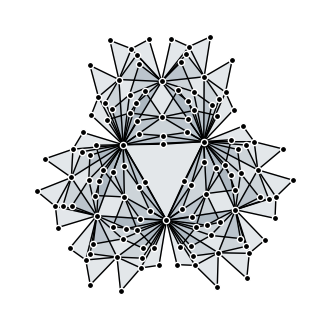

In [79]:

steps = 4
#sc = scomplex.apollonian_d2(steps)
sc = scomplex.pseudofractal_d2(steps)

# Plot simplicial complex (might be slow)

f,ax = plt.subplots(1,1,figsize = (4,4))
plotting.plot_complex(sc,ax = ax,face_color=[colors[2]],layout = "spring", iterations = 1000, node_size=20)
ax.collections[0].set_linewidth(1) 
ax.collections[0].set_edgecolor("#FFFFFF") 

Compute the entropic susceptibilities associated to the simplicial complex.

In [80]:
# Define the string specifying the cross-order Laplacians to consider

laplacians_types = ["01","02","10","12","20","21"]

sparse = False
num_eigs = 500

# Compute eigenvalues of the Laplacians and their entropic susceptibilities 

taumin = -4 # C curve starts from 10**taumin
taumax = 5 # C curve ends at 10**taumax
ntau = 200 # Number of times to consider in the interval

C_curves = []
sp_dims = []

for l in laplacians_types:  
    #print(f"L_({l[0]},{l[1]})")  
    L = scomplex.XO_laplacian(sc, k=int(l[0]), l=int(l[1]),sparse = sparse)
  
    if sparse:
        D,U = scipy.sparse.linalg.eigsh(L.asfptype(),k = num_eigs, which = "SM")
        D = np.append(D,1000000*np.ones(L.shape[0]-num_eigs),axis=0)
    else:
        D,U = np.linalg.eigh(L)
        D = np.abs(D)

    entropic_susceptibility,tau_space, __ = renormalize.compute_entropic_C(D,taumin,taumax,ntau)
    spectral_dimension,tau_space = renormalize.compute_spectral_d(D,taumin,taumax,ntau)
    C_curves.append(entropic_susceptibility)
    sp_dims.append(spectral_dimension)


/Users/marconurisso/Desktop/Lavoro/Simplicial_Renormalization/HodgeLaplacianRenorm/higher_order_LRG/HOLR/Experiments_setups/../Functions/renormalize.py:28: RuntimeWarning: overflow encountered in exp
  mu[i] = 1 / np.sum(np.exp(-tau * (D - D[i])))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


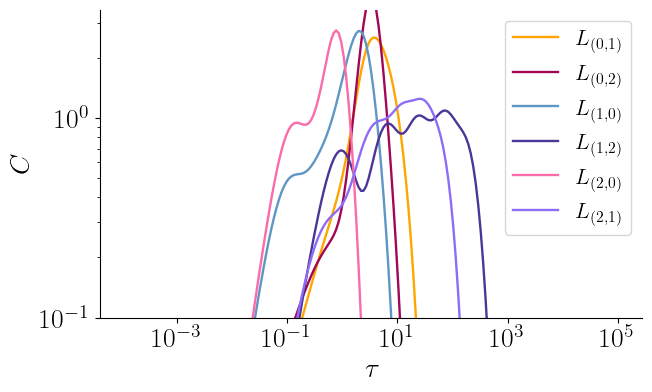

In [81]:
names = [f"$L_{{({int(l[0])},{int(l[1])})}}$" for l in laplacians_types]
f,ax = plt.subplots(1,1,figsize = (7,4))
for id,i in enumerate(laplacians_types):
    ax.loglog(tau_space,C_curves[id],color = colors_curves[id+1],linewidth = 1.7,alpha = 1)


ax.set_ylim([10**-1,3.5])
#ax.set_xlim([10**-2,10**3])

ax.legend(names,fontsize = 16)

ax.set_xlabel(r"$\tau$",fontsize = 20)
ax.set_ylabel(r"$C$",fontsize = 20)

plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

sns.despine()


Renormalize the simplicial complex

123
78
69


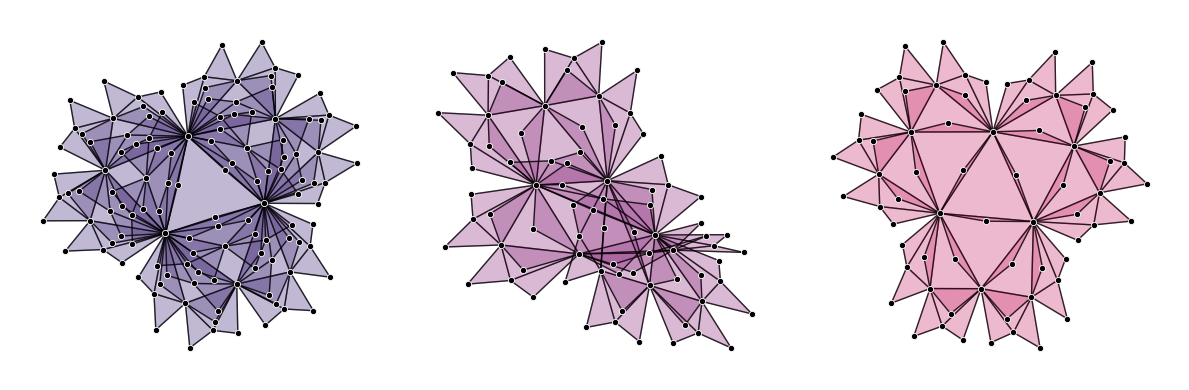

In [82]:
lmax = 3 # Number of steps
diff_order = 1 # Diffusion order
int_order = 2 # Interaction order
tau = 2 # Diffusion time
VERBOSE = True # Whether to print the number of nodes after each step

sequence = renormalize.renormalize_steps(sc,lmax = lmax,tau = tau, diff_order = diff_order, int_order = int_order, VERBOSE = VERBOSE)

# Plot sequence
f,axs = plt.subplots(1,lmax,figsize = (4*lmax,4))
i = 0
for new_sc in sequence:
    col = colors_sequential[i+2]
    plotting.plot_complex(new_sc,ax = axs[i],face_color=[col],face_alpha=0.4,node_size=20,iterations=1000)
    axs[i].collections[1].set_alpha(0.8)
    axs[i].collections[0].set_linewidth(0.6) 
    axs[i].collections[0].set_edgecolor("#FFFFFF") 
    i+=1
plt.tight_layout()


## Extra visualization

In [83]:
import networkx as nx
import matplotlib.colors as mcolors
layout = nx.spring_layout(nx.from_edgelist(sc["edges"]), iterations=1000)


Visualize the density matrix and the clustering of the simplices.

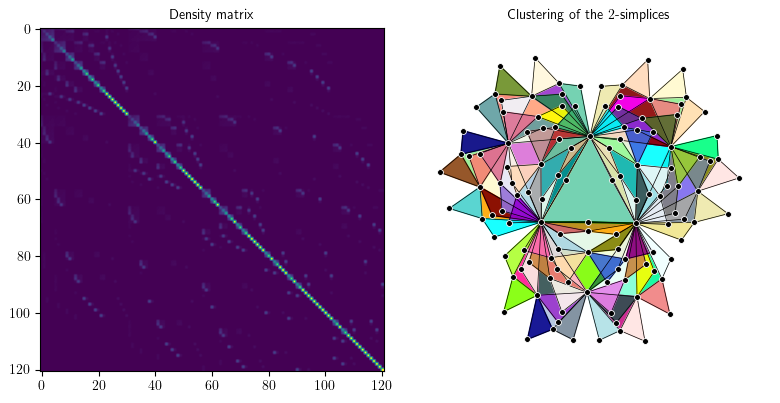

In [84]:
k = 2 # Diffusion order
m = 1 # Interaction order
tau = 0.3 # Diffusion time

L = scomplex.XO_laplacian(sc,k,m,False)
rho = scipy.linalg.expm(-tau*L) # Density matrix

# Compute metagraph
Gv = nx.Graph()
Gv.add_nodes_from([i for i in range(sc[f"n{k}"])])
for i in range(sc[f"n{k}"]):
    for j in range(i+1,sc[f"n{k}"]):
        if rho[i,j] >= min(rho[i,i],rho[j,j]):
            Gv.add_edge(i,j)


idx_components = {u:i for i,node_set in enumerate(nx.connected_components(Gv)) for u in node_set}
clusters = [idx_components[u] for u in Gv.nodes]

clist = list(mcolors.CSS4_COLORS)*10
np.random.shuffle(clist)

colors = clusters.copy()
for i in range(len(clusters)):
    colors[i] = clist[clusters[i]]

f,ax = plt.subplots(1,2,figsize = (8,4))

ax[0].imshow(rho/np.trace(rho))
ax[0].set_title("Density matrix")

if k == 0:
    plotting.plot_complex(sc,ax = ax[1],pos=layout,edge_width=0.5,node_size=30,face_alpha=0.1, node_color=colors)
    ax[1].collections[1].set_alpha(0.1)
    ax[1].collections[0].set_linewidth(0.6) 
    ax[1].collections[0].set_edgecolor("#FFFFFF") 
elif k == 1:
    plotting.plot_complex(sc,ax = ax[1],pos=layout,edge_width=2.5,node_size=12,face_alpha=0.1, edge_color=colors)
    ax[1].collections[1].set_alpha(1)
    ax[1].collections[0].set_linewidth(0.6) 
    ax[1].collections[0].set_edgecolor("#FFFFFF") 
elif k == 2:
    plotting.plot_complex(sc,ax = ax[1],face_color=colors,pos=layout,edge_width=0.5,node_size=18,face_alpha=0.9)
    ax[1].collections[1].set_alpha(1)
    ax[1].collections[0].set_linewidth(0.6) 
    ax[1].collections[0].set_edgecolor("#FFFFFF") 
ax[1].set_title(f"Clustering of the ${k}$-simplices")

plt.tight_layout()